In [17]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

In [18]:
df = pd.read_csv('training_data.csv')
df['YearMonth'] = pd.to_datetime(df['YearMonth'])

In [19]:
# Prepare data for Prophet
def prepare_data_for_prophet(df, zipcode):
    zipcode_data = df[df['zipcode'] == zipcode].sort_values('YearMonth')
    prophet_df = zipcode_data[['YearMonth', 'AveragePrice']].rename(columns={'YearMonth': 'ds', 'AveragePrice': 'y'})
    return prophet_df

In [20]:
# Function to fit Prophet model and make predictions
def fit_and_predict_prophet(data, steps=60):
    model = Prophet(yearly_seasonality=True, daily_seasonality=False)
    model.fit(data)
    future = model.make_future_dataframe(periods=steps, freq='M')
    forecast = model.predict(future)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], model

In [21]:
# Function to calculate ROI
def calculate_roi(initial_price, final_price):
    return (final_price - initial_price) / initial_price


In [22]:
# Function to get top 5 zipcodes based on ROI
def get_top_zipcodes_prophet(df, borough, max_price, years=[1, 3, 5]):
    borough_data = df[df['Borough'] == borough]
    affordable_zipcodes = borough_data[borough_data['AveragePrice'] <= max_price]['zipcode'].unique()
    
    results = []
    for zipcode in affordable_zipcodes:
        zipcode_data = prepare_data_for_prophet(df, zipcode)
        if len(zipcode_data) < 24:  
            continue
        
        current_price = zipcode_data['y'].iloc[-1]
        forecast, model = fit_and_predict_prophet(zipcode_data)
        
        roi_results = {}
        for year in years:
            future_price = forecast['yhat'].iloc[12*year - 1]
            roi = calculate_roi(current_price, future_price)
            roi_lower = calculate_roi(current_price, forecast['yhat_lower'].iloc[12*year - 1])
            roi_upper = calculate_roi(current_price, forecast['yhat_upper'].iloc[12*year - 1])
            roi_results[f'{year}Yr_ROI'] = roi
            roi_results[f'{year}Yr_ROI_Lower'] = roi_lower
            roi_results[f'{year}Yr_ROI_Upper'] = roi_upper
        
        historical_forecast = forecast[:len(zipcode_data)]
        mae = mean_absolute_error(zipcode_data['y'], historical_forecast['yhat'])
        r2 = r2_score(zipcode_data['y'], historical_forecast['yhat'])
        
        results.append({
            'zipcode': zipcode,
            'current_price': current_price,
            'MAE': mae,
            'R²': r2,
            **roi_results
        })
    
    results_df = pd.DataFrame(results)
    return results_df.nlargest(5, '5Yr_ROI')

In [23]:
# Function to plot historical prices and forecasts
def plot_forecast_prophet(df, zipcode, forecast):
    plt.figure(figsize=(12, 6))
    historical_data = prepare_data_for_prophet(df, zipcode)
    plt.plot(historical_data['ds'], historical_data['y'], label='Historical')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='k', alpha=0.1)
    plt.title(f'Housing Price Forecast for Zipcode {zipcode}')
    plt.xlabel('Date')
    plt.ylabel('Average Price')
    plt.legend()
    plt.show()

In [24]:
# Main function to run the analysis
def run_analysis_prophet(df, borough, max_price):
    top_zipcodes = get_top_zipcodes_prophet(df, borough, max_price)
    print(f"Top 5 Zipcodes in {borough} under ${max_price:,}:")
    print(top_zipcodes[['zipcode', 'current_price', '1Yr_ROI', '3Yr_ROI', '5Yr_ROI', 'MAE', 'R²']])
    
    for _, row in top_zipcodes.iterrows():
        zipcode = row['zipcode']
        zipcode_data = prepare_data_for_prophet(df, zipcode)
        forecast, _ = fit_and_predict_prophet(zipcode_data)
        plot_forecast_prophet(df, zipcode, forecast)


19:30:17 - cmdstanpy - INFO - Chain [1] start processing
19:30:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
19:30:18 - cmdstanpy - INFO - Chain [1] start processing
19:30:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
19:30:19 - cmdstanpy - INFO - Chain [1] start processing
19:30:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
19:30:19 - cmdstanpy - INFO - Chain [1] start processing
19:30:19 - cmdstanpy - INFO - Chain [1] done processing

Top 5 Zipcodes in Manhattan under $1,500,000:
    zipcode  current_price   1Yr_ROI   3Yr_ROI   5Yr_ROI           MAE  \
25    10035         599463  0.084331  0.205877  0.481028   9373.424273   
0     10001        1675072 -0.061597  0.103307  0.442418  32664.799887   
7     10014        1628708 -0.045645  0.098593  0.396088  28503.898744   
3     10005        1075476  0.081977  0.142222  0.329121  10556.050378   
10    10018        1306133 -0.109323  0.035518  0.324861  14708.624360   

          R²  
25  0.996462  
0   0.992265  
7   0.990718  
3   0.992254  
10  0.995207  


19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


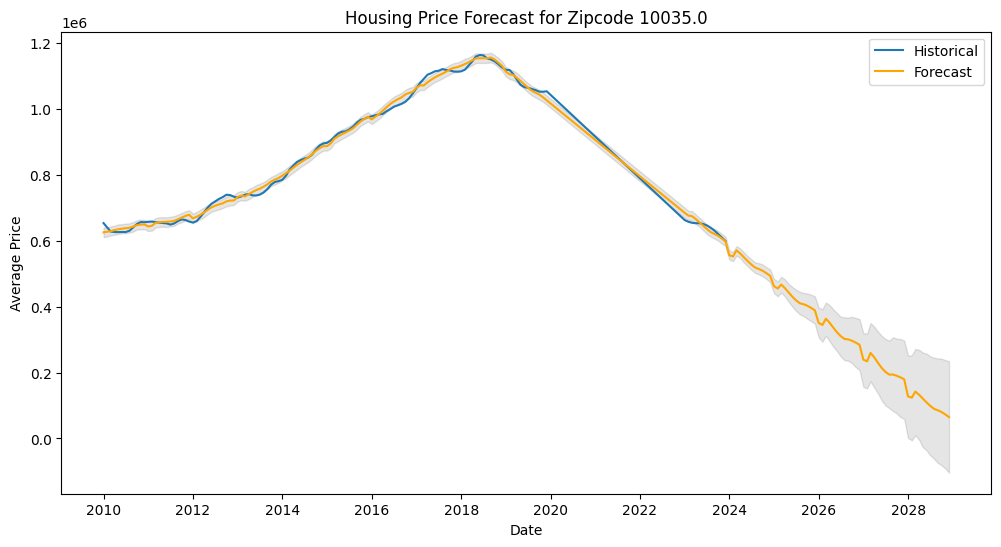

19:30:38 - cmdstanpy - INFO - Chain [1] start processing
19:30:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


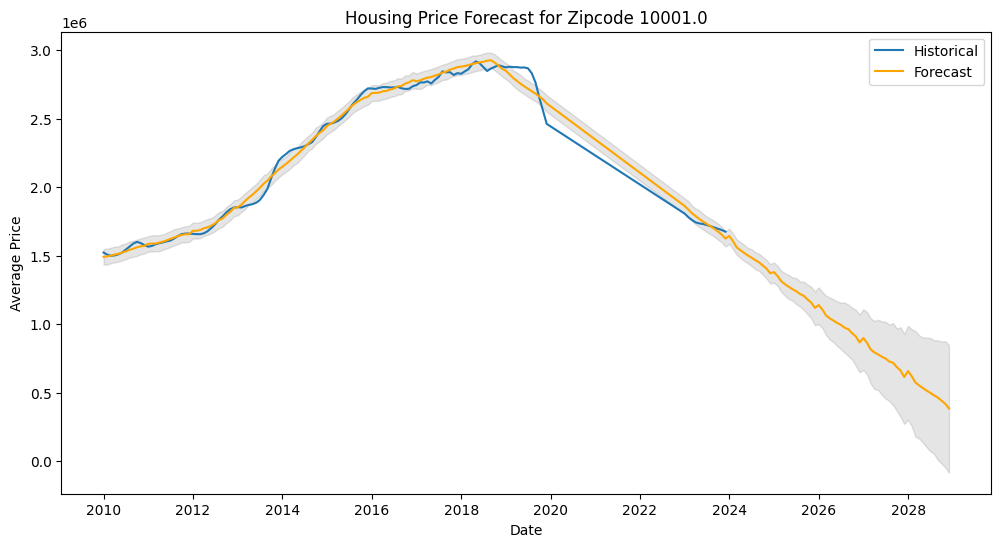

19:30:40 - cmdstanpy - INFO - Chain [1] start processing
19:30:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


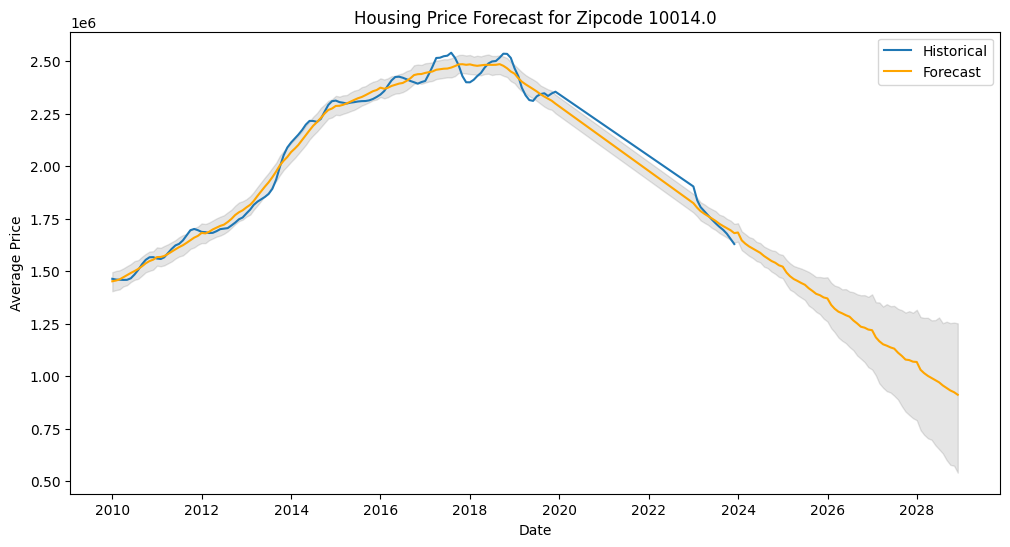

19:30:41 - cmdstanpy - INFO - Chain [1] start processing
19:30:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


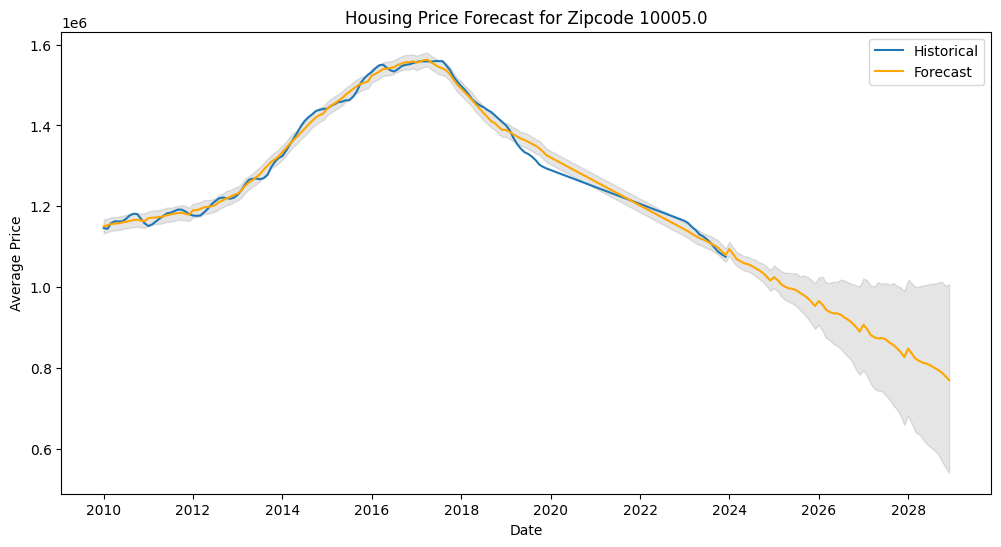

19:30:43 - cmdstanpy - INFO - Chain [1] start processing
19:30:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


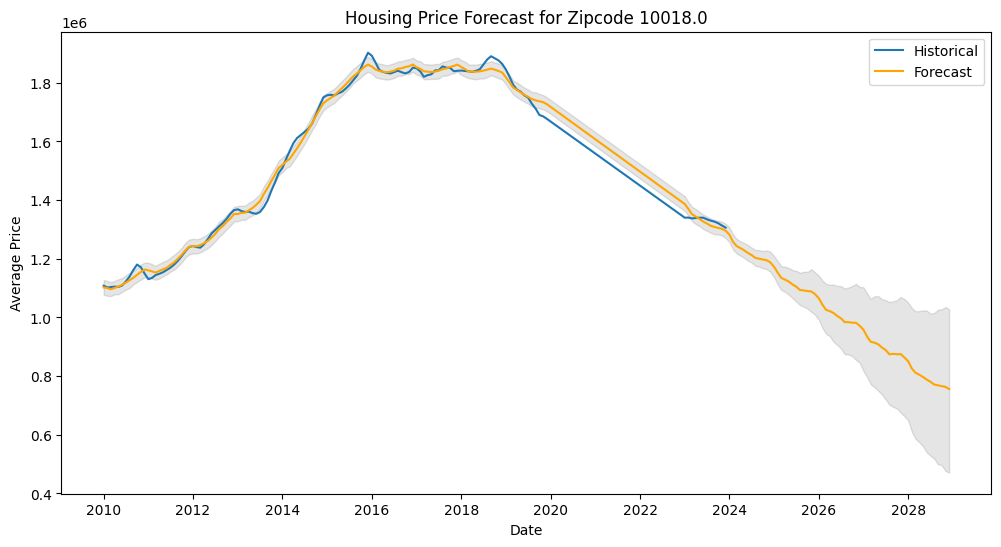

In [25]:
# Example usage
borough = 'Manhattan'  # User input
max_price = 1500000  # User input

run_analysis_prophet(df, borough, max_price)